# Biweekly-Checkin 3
# Jacob Tiede
## EDA on CIFAR-10
I think I want to go back and look at the CIFAR-10 dataset more closely. I would like to get some of the skills required to do EDA on these types of datasets, so I think I'll first copy some code from last week's bi-weekly report, and I'll take a look at what I can learn about the data (to reiterate the source of this data: https://www.cs.toronto.edu/~kriz/cifar.html). Note: we will only use the first 10,000 images from the data (the first file on the website) for this analysis, but since it is EDA we can extrapolate many of the trends we see to the rest of the data:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import torchvision.transforms.functional as TF
import os
import matplotlib.pyplot as plt

In [5]:
#code for this part from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle("./Data/cifar-10-batches-py/data_batch_1")

#Print some basics about the data:
print("The keys in our data dictionary:")
print(data.keys())
print("The shape of the data:")
print(data[b'data'].shape)
print("The shape of the labels:")
print(len(data[b'labels']))

#now, from the documentation we know that each image is a 32x32x3 image, and we can see that these have been flattened into a single array.
#we'll need to change this into something pytorch can work with for convolutional nets

train_x = torch.from_numpy(data[b'data'])
train_x = train_x.view(-1,3,32,32)
print("Our training data's shape:")
print(train_x.shape)

train_y = np.array(data[b'labels'])
train_y = torch.from_numpy(train_y)

The keys in our data dictionary:
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
The shape of the data:
(10000, 3072)
The shape of the labels:
10000
Our training data's shape:
torch.Size([10000, 3, 32, 32])


In [6]:
print("The max pixel value for each pixel channel is:")
print(torch.max(torch.max(torch.max(train_x, dim = 2)[0], dim = 2)[0], dim = 0)[0])
print("The mean pixel value for each pixel channel is (in the order RGB):")
print(torch.mean(torch.mean(torch.mean(train_x.float(), dim = 2), dim = 2), dim = 0))
print("The median pixel value for each pixel channel is (in the order RGB):")
print(torch.median(torch.median(torch.median(train_x.float(), dim = 2)[0], dim = 2)[0], dim = 0)[0])
print("The minimum pixel value for each pixel channel is:")
print(torch.min(torch.min(torch.min(train_x, dim = 2)[0], dim = 2)[0], dim = 0)[0])

The max pixel value for each pixel channel is:
tensor([255, 255, 255], dtype=torch.uint8)
The mean pixel value for each pixel channel is (in the order RGB):
tensor([125.8315, 123.2605, 114.0309])
The median pixel value for each pixel channel is (in the order RGB):
tensor([121., 118., 102.])
The minimum pixel value for each pixel channel is:
tensor([0, 0, 0], dtype=torch.uint8)


We can see that all of our image channels are on a scale from 0 to 255, and all of the means are relatively close to one another, though they are all right skewed (the mean is greater than the median for each channel). Interestingly, there seems to be less blue on average in the images. Now let's get an idea of what each class looks like by plotting an image from each class:

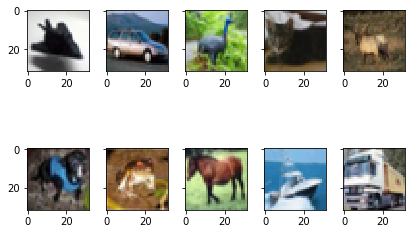

In [7]:
fig, axs = plt.subplots(2, 5, sharey=True)
fig.tight_layout()
k = 0
l = 0
for i in torch.unique(train_y):
    for j in range(train_x.shape[0]):
        if train_y[j] == i:
            img = train_x[j,:,:,:].numpy()
            axs[k,l].imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
            l+=1
            if l == 5:
                l = 0
                k = 1
            break

Taking a look at a representative example of an image from each class gives some valuable insight into why this might be a difficult problem for computers to answer. The pictures are so low resolution that I'm not even sure what some of them are exactly. Now, from the wikipedia page (https://en.wikipedia.org/wiki/CIFAR-10) on the CIFAR-10 dataset we know that the classes are: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Given this information it is much easier to make this determination, but there is still certainly some ambiguity. I suppose the next question to ask is: are any of these classes over represented in the data?

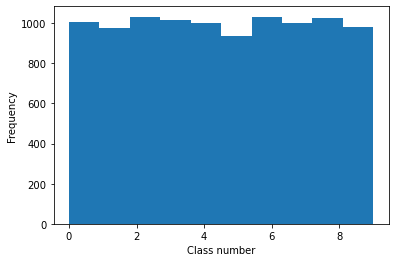

In [8]:
plt.hist(train_y.numpy(), bins = 10)
plt.xlabel("Class number")
plt.ylabel("Frequency")
plt.show()

There's some slight variation, but nothing drastic enough to require class balancing (at least in my opinion). Another pertinent question is: what does the pixel to pixel correlations look like for each class. To do this, it might first be easier to change the images to grayscale (in temporary variables) since the correlations should still go through, but we will get increased readability in the final plot. Implementing this: 

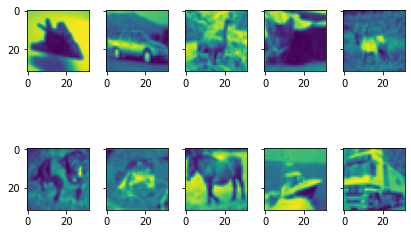

In [9]:
import torchvision.transforms as transforms
#Make another tensor of gray scale images
gray_scale_imgs = torch.zeros(train_x.shape[0], train_x.shape[2], train_x.shape[3])
for i in range(train_x.shape[0]):
    img = train_x[i,:,:,:]
    img = transforms.ToPILImage(mode='RGB')(img)
    img = transforms.functional.to_grayscale(img)
    gray_scale_imgs[i,:,:] = transforms.ToTensor()(img)

#Plot the gray scaled images
fig, axs = plt.subplots(2, 5, sharey=True)
fig.tight_layout()
k = 0
l = 0
for i in torch.unique(train_y):
    for j in range(train_x.shape[0]):
        if train_y[j] == i:
            img = gray_scale_imgs[j,:,:].numpy()
            axs[k,l].imshow(img)
            l+=1
            if l == 5:
                l = 0
                k = 1
            break

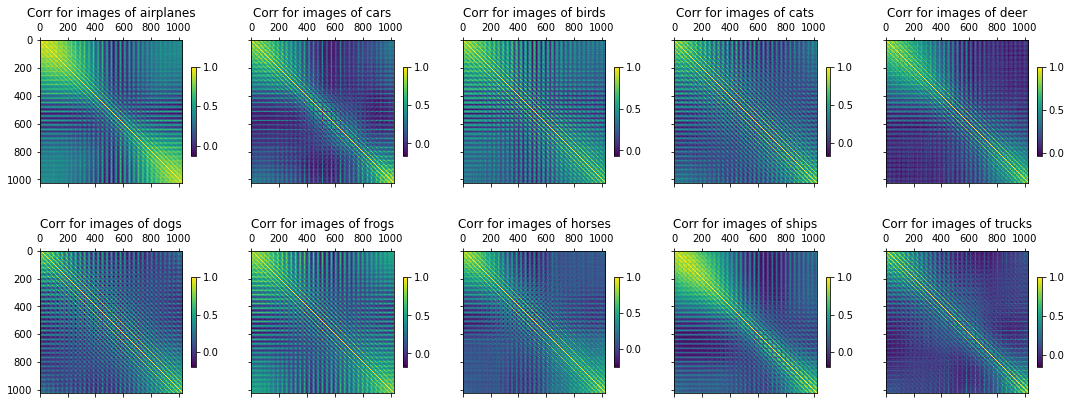

In [10]:
#first we need to construct a pandas dataframe with our data:
#Pandas is always somewhat hard for me to work with, so I'll use this as a reference: 
#https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html

#create a numpy array with all of our data (but first linearize all of our images)
gray_scale_imgs_temp = gray_scale_imgs.view(-1, gray_scale_imgs.shape[1]*gray_scale_imgs.shape[2])
fullData = np.zeros((gray_scale_imgs_temp.shape[0], gray_scale_imgs_temp.shape[1]+1))
fullData[:, 0:gray_scale_imgs_temp.shape[1]] = gray_scale_imgs_temp.numpy()
fullData[:, fullData.shape[1]-1] = train_y.numpy()

#we'll need a separate correlation plot for each class
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=True)
fig.tight_layout()
k = 0
l = 0
namesOfClasses = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
for i in torch.unique(train_y):
    #create a mask that will select just the class that we want to look at pixelwise correlations
    mask = np.ones(fullData[:, fullData.shape[1]-1].shape[0], dtype = bool)
    for j in range(mask.shape[0]):
        if fullData[:, fullData.shape[1]-1][j] != i:
            mask[j] = 0
    #select just the images that we are interested in
    temp = fullData[mask, 0:gray_scale_imgs_temp.shape[1]]
    temp = pd.DataFrame(data = temp, columns = list(range(temp.shape[1])))
    corr = temp.corr()
    temp = axs[k,l].matshow(corr)
    #see here for more details: 
    #https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/multi_image.html#sphx-glr-gallery-images-contours-and-fields-multi-image-py
    cb = plt.colorbar(temp, ax = axs[k,l], shrink = .5) 
    axs[k,l].set_title("Corr for images of " + namesOfClasses[i])
    l+=1
    if l == 5:
        l = 0
        k = 1

There is a clear difference in many of these images, for instance you can see that (qualitatively) airplanes have more pixel wise correlation than cars, and birds have even more than airplanes. It looks like the images with the least correlations between pixels are trucks, so I wonder if prediction is more difficult on these images. 

Another pertinent question might be: what does the average member of each class look like. We can do this by averaging all of the images from each class together and showing them: 

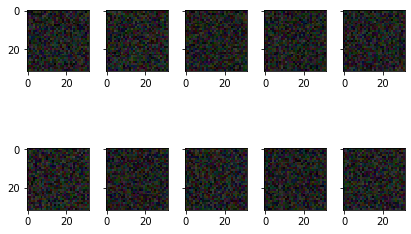

In [11]:
fig, axs = plt.subplots(2, 5, sharey=True)
fig.tight_layout()
k = 0
l = 0
for i in torch.unique(train_y):
    flag = 0
    numIm = 0
    for j in range(train_x.shape[0]):
        if train_y[j] == i:
            if numIm == 0:
                img = train_x[j,:,:,:].numpy()
                numIm += 1
            else:
                img += train_x[j,:,:,:].numpy()
                numIm += 1
        if j == train_x.shape[0]-1 and flag == 0:
            flag = 1
            img = img/numIm
            axs[k,l].imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
            l+=1
            if l == 5:
                l = 0
                k = 1

These images seem fine, with no preference for the placement of the object that we are trying to classify, they all just look like random noise. One possible "base-line" strategy for classification would be to just see which class average pixel the image is closest to and classify it that way. This might provide a valuable "check" for any method we implement since if our model performs worse than this deterministic method then we know we're in trouble. Implementing this: 

In [12]:
k = 0
l = 0
means = []
for i in torch.unique(train_y):
    flag = 0
    numIm = 0
    for j in range(train_x.shape[0]):
        if train_y[j] == i:
            if numIm == 0:
                img = train_x[j,:,:,:].numpy()
                numIm += 1
            else:
                img += train_x[j,:,:,:].numpy()
                numIm += 1
        if j == train_x.shape[0]-1 and flag == 0:
            flag = 1
            img = img/numIm
            img = torch.from_numpy(img)
            means.append(img)
acc = 0
for i in range(train_x.shape[0]):
    dist = 1000000
    for j in range(len(means)):
        if dist > torch.dist(train_x[i,:,:,:], means[j]):
            dist = torch.dist(train_x[i,:,:,:], means[j])
            pred = j
    if train_y[i] == pred:
        acc+=1
print("The accuracy of this baseline strategy is: " + str(acc/train_x.shape[0]))

The accuracy of this baseline strategy is: 0.0947


As you can see, this baseline strategy is no better than guessing, but it is a good check to make sure our models will do better than a naive approach. A better baseline might be to use PCA on this data then classify it. PCA is a means of dimensionality reducation, and is often implemented when there is a large number of features (like in the case of images). Following the tutorial found at https://towardsdatascience.com/eigenfaces-face-classification-in-python-7b8d2af3d3ea we can easily implement this (note that we will use a support vector machine to do the classification, but convolutional neural nets should outperform this method for image data, so this still provides a base-line result):

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [14]:
#much of the following code blocks are from: https://towardsdatascience.com/eigenfaces-face-classification-in-python-7b8d2af3d3ea 
train_x = train_x.view(-1, 3*train_x.shape[2]*train_x.shape[3])
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=4)

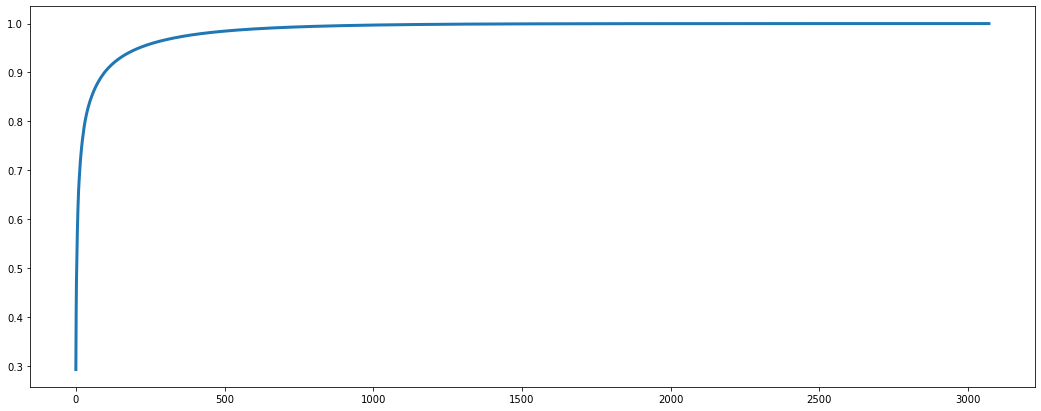

In [15]:
pca = PCA().fit(train_x)
plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [16]:
#Choose the number of principal components to use:
numComp = np.min(np.where(pca.explained_variance_ratio_.cumsum() > 0.95))
print("The number of principal components that we will use is: " + str(numComp))

The number of principal components that we will use is: 212


In [17]:
pca = PCA(n_components=numComp).fit(train_x)
train_pca = pca.transform(train_x)
clf = SVC().fit(train_pca, train_y)
test_pca = pca.transform(test_x)
pred = clf.predict(test_pca)

In [18]:
#Get the accuracy:
acc = 0
for i in range(pred.shape[0]):
    if pred[i] == test_y[i]:
        acc+=1
print("The accuracy using PCA and SVMs is: " + str(acc/pred.shape[0]))

The accuracy using PCA and SVMs is: 0.46


The accuracy is much better than the simple approach we detailed before, but it still isn't great. In fact, looking back to my second biweekly report, I was able to get an accuracy of .456 using a very simple CNN model based off of LeNet, so this accuracy is easily attainable with neural nets. I do wonder if normalization might help these predictions. We already know that the data is skewed somewhat (see the beginning of the EDA where we compare channel wise means with channel wise medians), so we know that it cannot be exactly normal. Implementing this same procedure with normalization:

In [19]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(train_x)

train_x = transformer.transform(train_x)
test_x = transformer.transform(test_x)

pca = PCA().fit(train_x)
#Choose the number of principal components to use:
numComp = np.min(np.where(pca.explained_variance_ratio_.cumsum() > 0.95))
print("The number of principal components that we will use is: " + str(numComp))

pca = PCA(n_components=numComp).fit(train_x)
train_pca = pca.transform(train_x)
clf = SVC().fit(train_pca, train_y)
test_pca = pca.transform(test_x)
pred = clf.predict(test_pca)

#Get the accuracy:
acc = 0
for i in range(pred.shape[0]):
    if pred[i] == test_y[i]:
        acc+=1
print("The accuracy using PCA and SVMs is: " + str(acc/pred.shape[0]))
print("The confusion matrix of SVMs applied to normalized CIFAR-10 data is:")
print(confusion_matrix(test_y, pred))
conMatrix = confusion_matrix(test_y, pred)
print("The by-class accuracy of each class prediction is:")
namesOfClasses = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
for i in range(len(namesOfClasses)):
    print(namesOfClasses[i] + ": " + str(conMatrix[i,i]/np.sum(conMatrix[:,i])))

The number of principal components that we will use is: 284
The accuracy using PCA and SVMs is: 0.479
The confusion matrix of SVMs applied to normalized CIFAR-10 data is:
[[52  3  4  1  5  4  0  2 16  2]
 [ 3 51  1  6  1  2  2  0  9 18]
 [12  8 40 17 10  5  7  5  5  0]
 [ 1  3 15 39  6 18 14  4  3  5]
 [ 8  4 24  8 41  7 16  5  2  2]
 [ 1  2 10 24  6 31  7  2  1  3]
 [ 2  5 12 15  7  7 50  2  0  6]
 [ 6  4  2  7  7  5  8 49  1  4]
 [ 7  4  3  2  5  1  2  0 64  9]
 [ 3 18  2  1  2  3  5  2  3 62]]
The by-class accuracy of each class prediction is:
airplanes: 0.5473684210526316
cars: 0.5
birds: 0.35398230088495575
cats: 0.325
deer: 0.45555555555555555
dogs: 0.37349397590361444
frogs: 0.45045045045045046
horses: 0.6901408450704225
ships: 0.6153846153846154
trucks: 0.5585585585585585


As you can see we now need more principal components to account for 95% of the variance, but this is a small price to pay for a rather sharp accuracy increase. It may not look like much, but for such a simple change even a small accuracy increase is huge. SVMs are now beating the initial neural net strategy in accuracy, which is impressive given that we are flattening the images and treating them like unordered tabular data. I think image normalization will definitely be an important step for all of my future projects involving prediction. It is also worth noting that cats, dogs, and birds were all very difficult for our model to classify. This is somewhat surprising since when we looked at the correlations between the images we found that these images had pixels that were highly correlated, so I had thought we might do well on these images. In fact, our model did quite well (relatively speaking) on trucks, which is somewhat surprising since we found that these images had some of the lowest correlations in the data set. This, however, might actually be the root of the problem. The pixel correlations for pixels that are far away from each other probably have nothing to do with whether or not this is a bird or not, rather they are probably extraneous, or unrelated to the fact that we are looking at a bird. For instance, many of the background pixels might be blue (since birds would be flying when we see them), so the model might associate blue sky with birds, but it should be clear that blue sky does not mean that a bird is in the image. 
### Final Thoughts
I have a much better idea of what CIFAR-10 looks like, and some of the potential problems I might run into for the classifiers that I will make. This is related to the potential project idea that I have, which is discussed in the README.md file in this repo.